# Setup/Imports

In [1]:
import pickle
import keras
import tensorflow as tf
from keras import backend as K
import numpy as np
import scipy.stats
import sys
import os
sys.path.append(os.path.abspath('../'))
import helpers
from helpers.data_generator import process_data, DataGenerator

from sklearn.metrics import r2_score
from time import strftime, localtime
import matplotlib
from matplotlib import pyplot as plt
import copy
%matplotlib inline
from helpers.normalization import normalize, denormalize, renormalize
from tqdm import tqdm

Using TensorFlow backend.
/home/wconlin/.conda/envs/tfgpu/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:458: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/wconlin/.conda/envs/tfgpu/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:459: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/wconlin/.conda/envs/tfgpu/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:460: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/wconlin/.conda/envs/tfg

In [2]:
config = tf.ConfigProto(intra_op_parallelism_threads=1,
                            inter_op_parallelism_threads=1,
                            allow_soft_placement=True,
                            device_count={'CPU': 1,
                                          'GPU': 0})
session = tf.Session(config=config)
K.set_session(session)


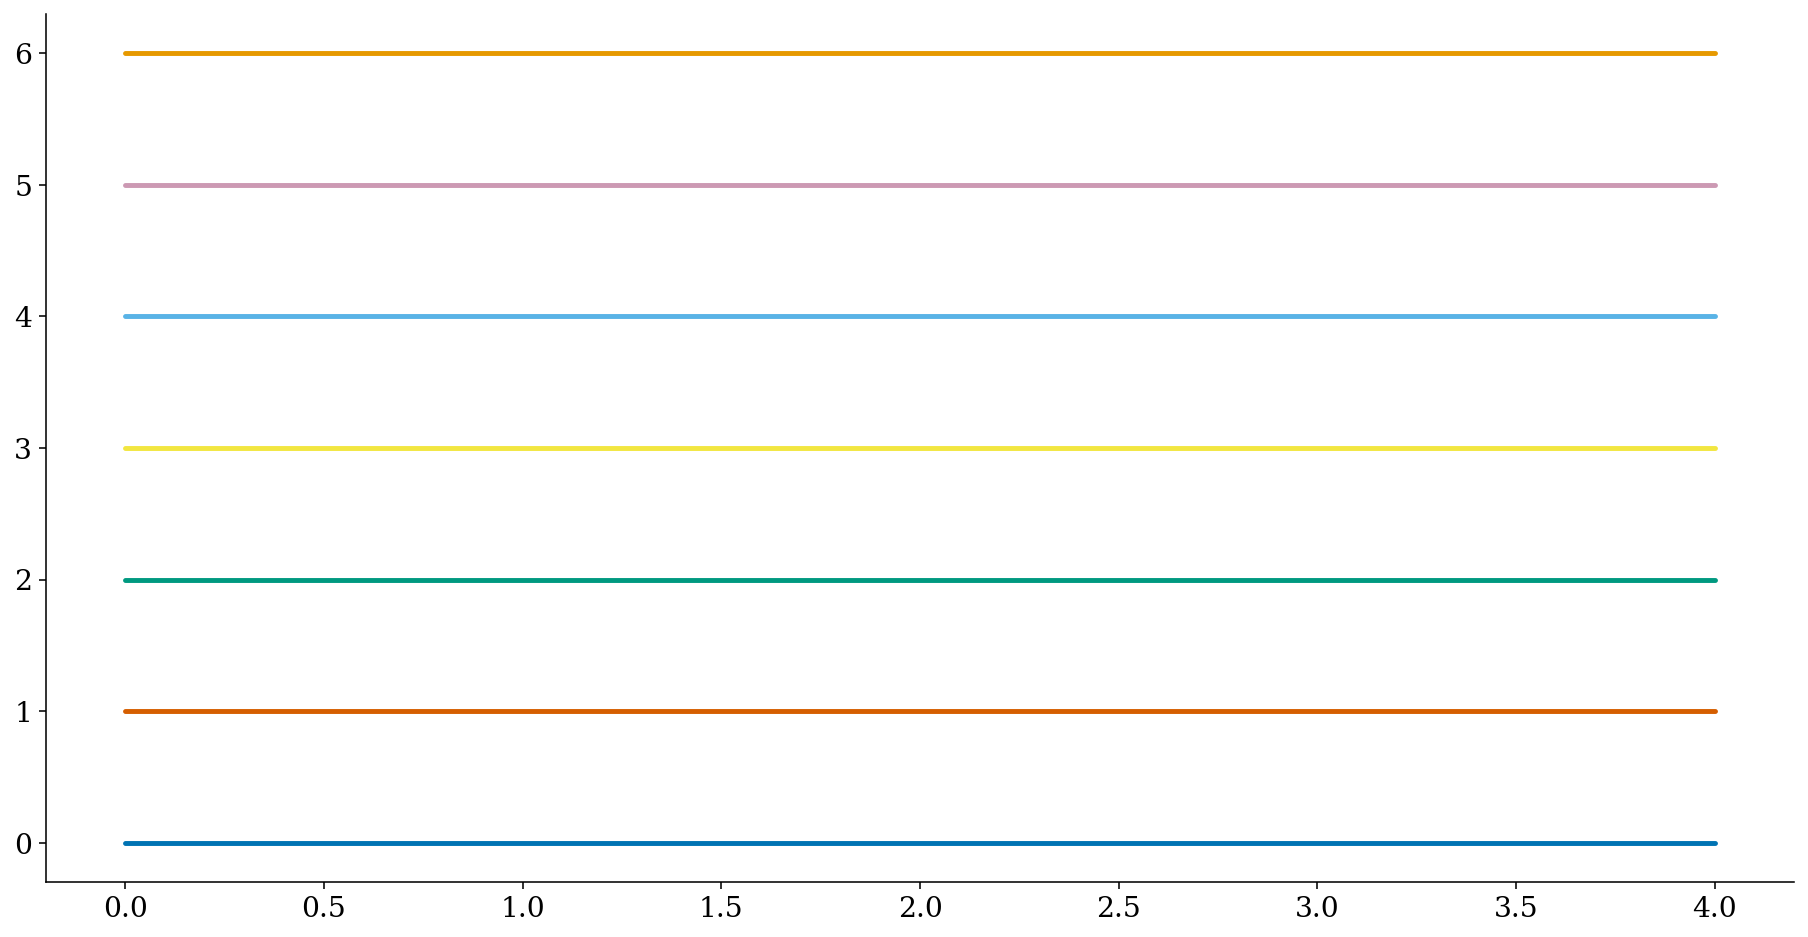

In [3]:
matplotlib_colors = [(0.1215, 0.4667, 0.7058), # blue
                     (1.0000, 0.4980, 0.0549), # orange
                     (0.1725, 0.6275, 0.1725), # green
                     (0.8392, 0.1529, 0.1568), # red
                     (0.5804, 0.4039, 0.7412), # violet
                     (0.4980, 0.4980, 0.4980), # grey
                     (0.0902, 0.7450, 0.8117)] # cyan

matlab_colors=[(0.0000, 0.4470, 0.7410), # blue
               (0.8500, 0.3250, 0.0980), # reddish orange
               (0.9290, 0.6940, 0.1250), # yellow
               (0.4940, 0.1840, 0.5560), # purple
               (0.4660, 0.6740, 0.1880), # light green
               (0.3010, 0.7450, 0.9330), # cyan
               (0.6350, 0.0780, 0.1840)] # dark red

colorblind_colors = [(0.0000, 0.4500, 0.7000), # blue
                     (0.8359, 0.3682, 0.0000), # vermillion
                     (0.0000, 0.6000, 0.5000), # bluish green
                     (0.9500, 0.9000, 0.2500), # yellow
                     (0.3500, 0.7000, 0.9000), # sky blue
                     (0.8000, 0.6000, 0.7000), # reddish purple
                     (0.9000, 0.6000, 0.0000)] # orange

dashes = [(1.0, 0.0, 0.0, 0.0, 0.0, 0.0), # solid
          (3.7, 1.6, 0.0, 0.0, 0.0, 0.0), # dashed
          (1.0, 1.6, 0.0, 0.0, 0.0, 0.0), # dotted
          (6.4, 1.6, 1.0, 1.6, 0.0, 0.0), # dot dash
          (3.0, 1.6, 1.0, 1.6, 1.0, 1.6), # dot dot dash
          (6.0, 4.0, 0.0, 0.0, 0.0, 0.0), # long dash
          (1.0, 1.6, 3.0, 1.6, 3.0, 1.6)] # dash dash dot

from matplotlib import rcParams, cycler
matplotlib.rcdefaults()
rcParams['font.family'] = 'DejaVu Serif'
rcParams['mathtext.fontset'] = 'cm'
rcParams['font.size'] = 12
rcParams['figure.facecolor'] = (1,1,1,1)
rcParams['figure.figsize'] = (16,8)
rcParams['figure.dpi'] = 141
rcParams['axes.spines.top'] = False
rcParams['axes.spines.right'] = False
rcParams['axes.labelsize'] =  'large'
rcParams['axes.titlesize'] = 'x-large'
rcParams['lines.linewidth'] = 2.5
rcParams['lines.solid_capstyle'] = 'round'
rcParams['lines.dash_capstyle'] = 'round'
rcParams['lines.dash_joinstyle'] = 'round'
rcParams['xtick.labelsize'] = 'large'
rcParams['ytick.labelsize'] = 'large'
# rcParams['text.usetex']=True
color_cycle = cycler(color=colorblind_colors)
dash_cycle = cycler(dashes=dashes)
rcParams['axes.prop_cycle'] =  color_cycle

labelsize=10
ticksize=8
for i,c in enumerate(colorblind_colors):
    plt.plot((i)*np.ones(5),c=c)

# Analysis

In [4]:
"""THIS IS THE ONE FROM THE PAPER AS OF 3/5"""
file_path='/home/jabbate/run_results_12_11/model-conv2d_profiles-dens-temp-q_EFIT01-rotation-press_EFIT01_act-curr_target-pinj-tinj-target_density-bt_targ-dens-temp-q_EFIT01-rotation-press_EFIT01_profLB-0_actLB-6_ftop-True_11Dec19-18-30_Scenario-12.h5'

# base_path = os.path.expanduser('~/run_results_02_13/')
# model_path = 'model-conv2d_profiles-dens-temp-itemp-q-rotation_act-target_density-pinj-tinj-curr_target_targ-dens-temp-itemp-q-rotation_profLB-0_actLB-6_ftop-True_15Feb20-20-16_Scenario-62.h5'
# file_path = base_path + model_path


model = keras.models.load_model(file_path, compile=False)
print('loaded model: ' + file_path.split('/')[-1])
file_path = file_path[:-3] + '_params.pkl'
with open(file_path, 'rb') as f:
    scenario = pickle.load(f, encoding='latin1')
print('loaded dict: ' + file_path.split('/')[-1])
print('with parameters: ' + str(scenario.keys()))

loaded model: model-conv2d_profiles-dens-temp-q_EFIT01-rotation-press_EFIT01_act-curr_target-pinj-tinj-target_density-bt_targ-dens-temp-q_EFIT01-rotation-press_EFIT01_profLB-0_actLB-6_ftop-True_11Dec19-18-30_Scenario-12.h5
loaded dict: model-conv2d_profiles-dens-temp-q_EFIT01-rotation-press_EFIT01_act-curr_target-pinj-tinj-target_density-bt_targ-dens-temp-q_EFIT01-rotation-press_EFIT01_profLB-0_actLB-6_ftop-True_11Dec19-18-30_Scenario-12_params.pkl
with parameters: dict_keys(['excluded_shots', 'model_type', 'epochs', 'model_kwargs', 'input_profile_names', 'target_profile_names', 'actuator_names', 'scalar_input_names', 'batch_size', 'process_data', 'predict_deltas', 'lookahead', 'profile_downsample', 'std_activation', 'sample_weighting', 'hinge_weight', 'mse_weight_power', 'mse_weight_edge', 'mse_power', 'flattop_only', 'raw_data_path', 'processed_filename_base', 'optimizer', 'optimizer_kwargs', 'shuffle_generators', 'pruning_functions', 'normalization_method', 'window_length', 'window_

In [5]:
orig_data_path = '/scratch/gpfs/jabbate/full_data/train_data_full.pkl'
test_data_path = '/scratch/gpfs/jabbate/full_data_with_error/test_data.pkl' 
traindata, valdata, normalization_dict = helpers.data_generator.process_data(test_data_path,
                                                      scenario['sig_names'],
                                                      scenario['normalization_method'],
                                                      scenario['window_length'],
                                                      scenario['window_overlap'],
                                                      scenario['lookbacks'],
                                                      scenario['lookahead'],
                                                      scenario['sample_step'],
                                                      scenario['uniform_normalization'],
                                                      1, #scenario['train_frac'],
                                                      0, #scenario['val_frac'],
                                                      scenario['nshots'],
                                                      2, #scenario['verbose']
                                                      scenario['flattop_only'],
                                                      randomize=False,
                                                      pruning_functions=scenario['pruning_functions'],
                                                      excluded_shots = scenario['excluded_shots'],
                                                      delta_sigs = [])
traindata = helpers.normalization.renormalize(helpers.normalization.denormalize(traindata.copy(),normalization_dict),scenario['normalization_dict'])


Loading
Signals: bt, curr_target, dens, density_estimate, li_EFIT01, pinj, press_EFIT01, q_EFIT01, rotation, target_density, temp, tinj, triangularity_bot_EFIT01, triangularity_top_EFIT01, volume_EFIT01
Number of useable shots:  1123
Number of shots used:  1123
Total number of timesteps:  124870
Shots with Complete NaN: 
86189 samples total
Removing ECH
Removed 46802 samples
39387 samples remaining
Removing timesteps WITHOUT gas feedback
Removed 5176 samples
34211 samples remaining
Removing weird I-coils
Removed 7495 samples
26716 samples remaining
Removing NaN
Removed 0 samples
26716 samples remaining
Removing dudtrip
Removed 620 samples
26096 samples remaining
26096 samples remaining after pruning


Normalizing:  26%|##6       | 6/23 [00:00<00:00, 57.73it/s]

Total number of samples:  26096
Number of training samples:  26096
Number of validation samples:  0


Normalizing: 100%|##########| 23/23 [00:00<00:00, 44.84it/s]


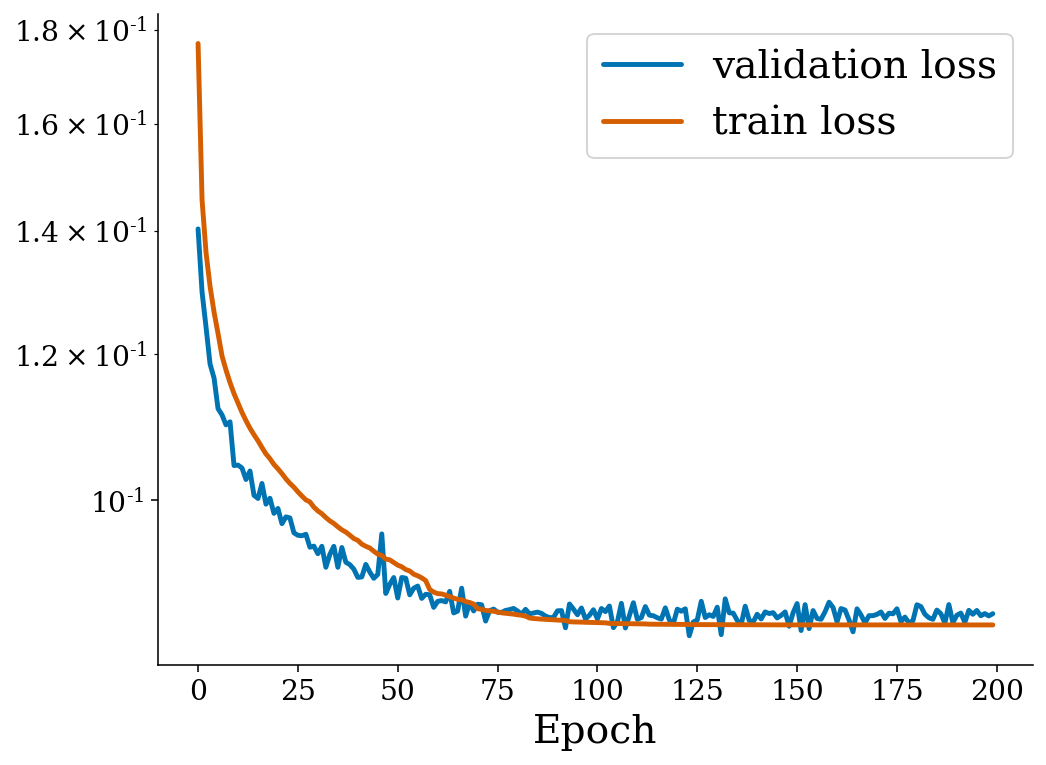

In [6]:
fig, ax = plt.subplots(figsize=(8,6))
ax.semilogy(scenario['history']['val_loss'],label='validation loss')
ax.semilogy(scenario['history']['loss'],label='train loss')
ax.set_xlabel('Epoch', size=20)
ax.legend(fontsize=20)
#plt.ylim(0,.1)
# fig.savefig('training.png')

In [7]:
denormed_traindata=helpers.normalization.denormalize(traindata.copy(),scenario['normalization_dict'])

Denormalizing: 100%|##########| 23/23 [00:00<00:00, 234.24it/s]


In [8]:
def normalize(arr,signal):
    if scenario['predict_deltas']:
        return arr*normalization_dict[signal]['iqr']
    else:
        return helpers.normalization.denormalize_arr(arr,normalization_dict[signal])

In [9]:
profiles=scenario['target_profile_names']
psi = np.linspace(0,1,scenario['profile_length'])

In [10]:
with open(os.path.expanduser('~/plasma-profile-predictor/pca_delta_fitters.pkl'),'rb') as f:
    full_pca_fitter = pickle.load(f, encoding='latin1')
with open(os.path.expanduser('~/plasma-profile-predictor/pca_delta_kernels.pkl'),'rb') as f:
    kernels = pickle.load(f, encoding='latin1')


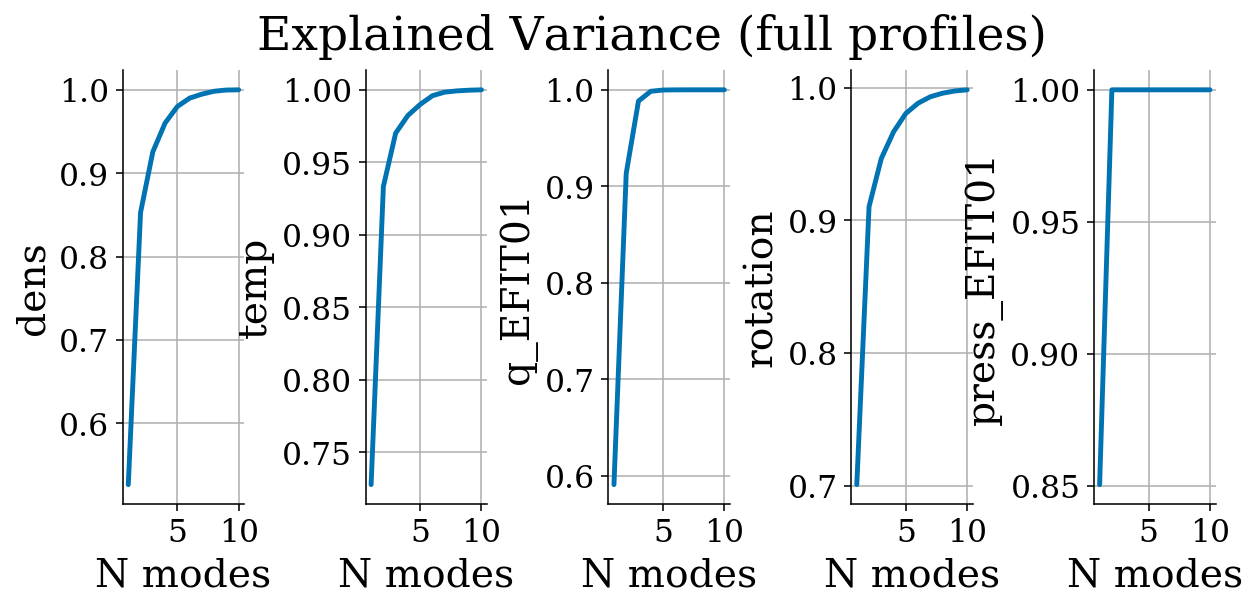

In [11]:
"""plot explained variance"""

ylabels = profiles #['$n_e$','$T_e$','$q$','$\Omega$','$P$']

fig, axes = plt.subplots(1,len(profiles),sharey=False,figsize=(10,4))
for j,profile in enumerate(profiles):
    pca=full_pca_fitter[profile]
    ax = axes[j]
    
    ax.plot(np.arange(1,pca.n_components+1),np.cumsum(pca.explained_variance_ratio_))
    ax.set_ylabel(ylabels[j],size=20)
    ax.set_xlabel('N modes', size=20)
#     ax.set_xticks(np.arange(1,pca.n_components+1))
    ax.grid()
    ax.tick_params(axis='both', which='both', labelsize=16)
#     ax.set_yscale('log')

#     ax.set_ylim((10**-3,100))
#     ax.axhline(0,c='k')
fig.suptitle('Explained Variance (full profiles)', size=24)
plt.subplots_adjust(wspace=1.0)
# fig.savefig('explained_variance.png')

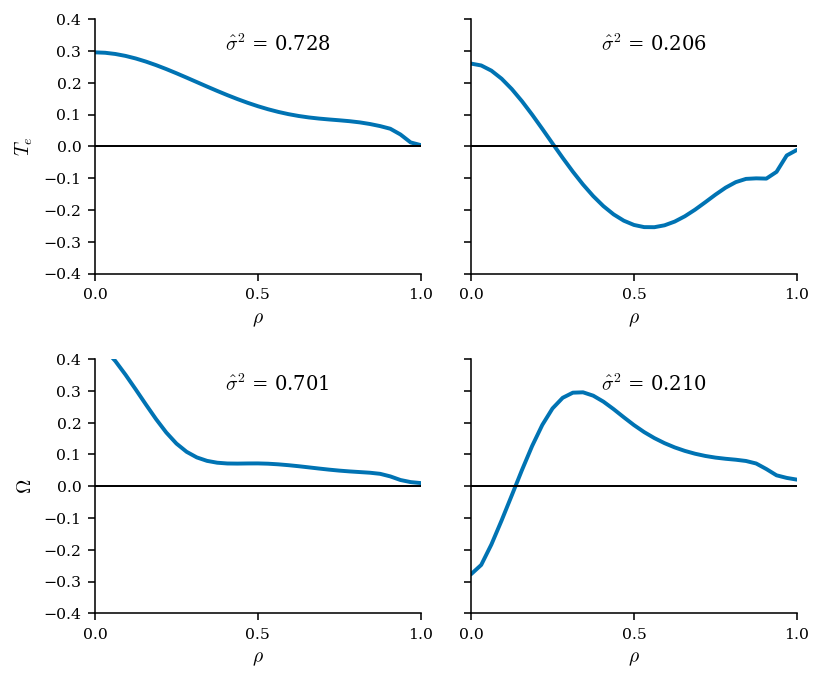

In [12]:
"""plot full pca modes"""

ncols = 5
nrows = 2
ylabels = profiles
# fig, axes = plt.subplots(len(profiles),nrows, sharex=False, sharey=True,figsize=(4,6))
fig, axes = plt.subplots(2,nrows, sharex=False, sharey=True,figsize=(6,5))


labels = ['$n_e$','$T_e$','$\Omega$','$q$','$P$']
profiles = ['dens','temp','rotation','q_EFIT01','press_EFIT01']
for j,profile in enumerate(profiles):
    pca=full_pca_fitter[profile]
    if profile in ['temp','rotation']:
        for i in range(nrows):
            ax= axes[j-1,i]
            ax.plot(psi,pca.components_[i],lw=2)
            ax.text(0.4,0.3,'$\hat{\sigma}^2$' + ' = {:.3f}'.format(pca.explained_variance_ratio_[i]),fontsize=labelsize)
            if i==0:
                ax.set_ylabel(labels[j], size=labelsize)
            if j==0:
                ax.set_title('PCA Mode {}'.format(i+1), size=labelsize)
            if j in [0,1,2]:
                ax.set_xlabel('$\\rho$',size=labelsize)
            if j in [3,4]:
                ax.set_xlabel('$\psi$',size=labelsize)
            ax.set_ylim(-.4,.4)
            ax.tick_params(axis='both', which='major', labelsize=ticksize)
            ax.set_xticks([0,.5,1])
            ax.set_xlim(0,1)

            ax.axhline(0,c='k',lw=1)
plt.subplots_adjust(hspace=0.8)
plt.tight_layout()
# fig.savefig('pca_modes.pdf')
# fig.savefig('pca_modes.png')

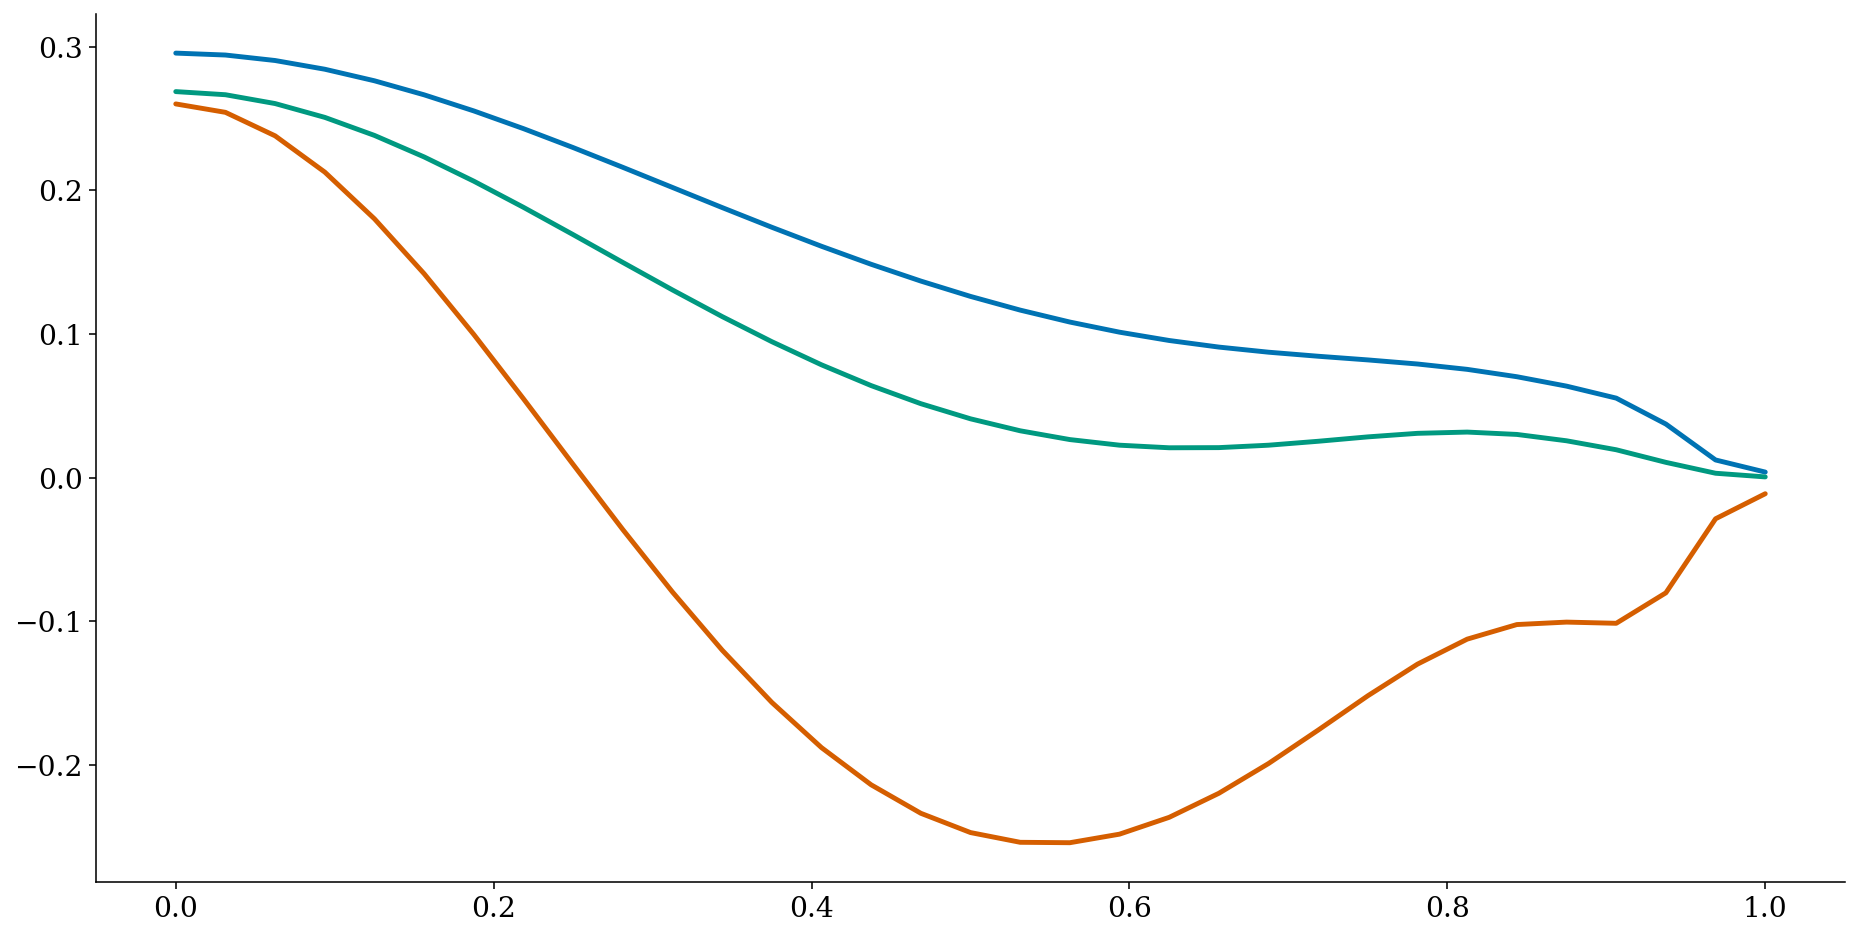

In [13]:
plt.plot(psi,full_pca_fitter['temp'].components_[0,:])
plt.plot(psi,full_pca_fitter['temp'].components_[1,:])
plt.plot(psi,.728*full_pca_fitter['temp'].components_[0,:]+.206*full_pca_fitter['temp'].components_[1,:])

# Average performance #

In [16]:
train_generator = DataGenerator(traindata,
                                1, #scenario['batch_size'],
                                scenario['input_profile_names'],
                                scenario['actuator_names'],
                                scenario['target_profile_names'],
                                scenario['scalar_input_names'],
                                scenario['lookbacks'],
                                scenario['lookahead'],
                                scenario['predict_deltas'],
                                scenario['profile_downsample'],
                                False,
                                sample_weights = 'std') #scenario['shuffle_generators'])

In [17]:
sigs=scenario['actuator_names']
profiles=scenario['target_profile_names']
input_profiles=scenario['input_profile_names']


num_samples = len(train_generator) 

big_baseline = {sig: [] for sig in scenario['target_profile_names']}
big_predictions = {sig: [] for sig in scenario['target_profile_names']}


k=0
indices = np.random.permutation(len(train_generator))
for index in indices:
    
    sample=train_generator[index]
    inputs=sample[0]
    targets=sample[1]
    
    # only include if mean change in standardized profiles is greater than .1 for at least one profile
    skip=np.zeros(len(profiles))
    for j,profile in enumerate(profiles):
        target=targets['target_{}'.format(profile)][0]
        if np.mean(abs(target))<.2:
            skip[j]=1
    if all(skip):
        continue

    if k%100==0:
        print(k,end=',')
        
    predictions=model.predict_on_batch(inputs)
    for i, sig in enumerate(scenario['target_profile_names']):
        big_baseline[sig].append(targets['target_'+sig])
        big_predictions[sig].append(predictions[i])

   
    k+=1
print('{} samples found'.format(k))
nsamples=k


0,100,200,300,400,500,600,700,800,900,1000,1100,1200,1300,1400,1500,1600,1700,1800,1900,2000,2100,2200,2300,2400,2500,2600,2700,2800,2900,3000,3100,3200,3300,3400,3500,3600,3700,3800,3900,4000,4100,4200,4300,4400,4500,4600,4700,4800,4900,5000,5100,5200,5300,5400,5500,5600,5700,5800,5900,6000,6100,6200,6300,6400,6500,6600,6700,6800,6900,7000,7100,7200,7300,7400,7500,7600,7700,7800,7900,8000,8100,8200,8300,8400,8480 samples found


In [18]:
big_pred = {sig: np.concatenate(arr,axis=0) for sig, arr in big_predictions.items()}
big_base = {sig: np.concatenate(arr,axis=0) for sig, arr in big_baseline.items()}

In [19]:
big_model_err = {sig: np.abs(big_pred[sig] - big_base[sig]) for sig in scenario['target_profile_names']}
big_baseline_err = {sig: np.abs(big_base[sig]) for sig in scenario['target_profile_names']}


In [20]:
hi_per = 75
low_per = 25

big_model_med = {sig:np.median(big_model_err[sig]*scenario['normalization_dict'][sig]['iqr'],axis=0) for sig in scenario['target_profile_names']}
big_baseline_med = {sig:np.median(big_baseline_err[sig]*scenario['normalization_dict'][sig]['iqr'],axis=0) for sig in scenario['target_profile_names']}

big_model_hiper = {sig:np.percentile(big_model_err[sig]*scenario['normalization_dict'][sig]['iqr'],hi_per,axis=0) for sig in scenario['target_profile_names']}
big_baseline_hiper = {sig:np.percentile(big_baseline_err[sig]*scenario['normalization_dict'][sig]['iqr'],hi_per,axis=0) for sig in scenario['target_profile_names']}

big_model_lowper = {sig:np.percentile(big_model_err[sig]*scenario['normalization_dict'][sig]['iqr'],low_per,axis=0) for sig in scenario['target_profile_names']}
big_baseline_lowper = {sig:np.percentile(big_baseline_err[sig]*scenario['normalization_dict'][sig]['iqr'],low_per,axis=0) for sig in scenario['target_profile_names']}

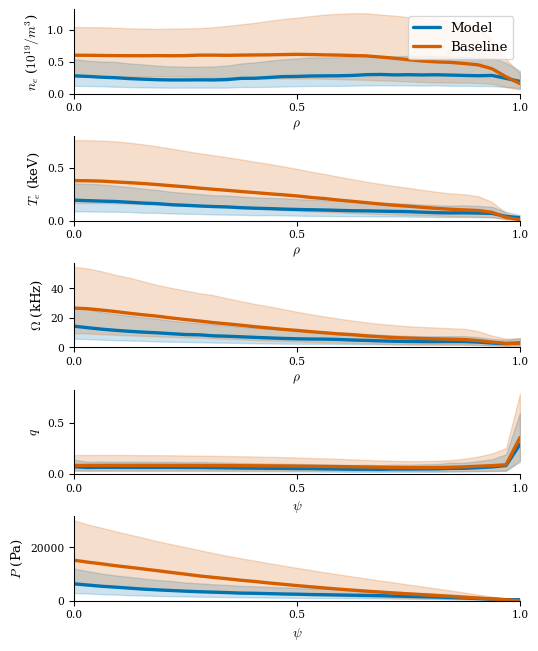

In [100]:
labels = ['$n_e$ ($10^{19}/m^3$)','$T_e$ (keV)','$\Omega$ (kHz)','$q$','$P$ (Pa)']
profiles = ['dens','temp','rotation','q_EFIT01','press_EFIT01']

fig, ax = plt.subplots(len(profiles),1,figsize=(6,8))

for i, sig in enumerate(profiles):
    ax[i].plot(psi,big_model_med[sig],c=colorblind_colors[0],label='Model')
    ax[i].fill_between(psi,big_model_lowper[sig],big_model_hiper[sig],color=colorblind_colors[0],alpha=0.2)    
    
    ax[i].plot(psi,big_baseline_med[sig],c=colorblind_colors[1],label='Baseline')
    ax[i].fill_between(psi,big_baseline_lowper[sig],big_baseline_hiper[sig],color=colorblind_colors[1],alpha=0.2)   
    ax[i].set_ylim(0,None)
    ax[i].set_ylabel(labels[i],size=labelsize)
    ax[i].tick_params(axis='both', which='major', labelsize=ticksize)
    if i==0:
        ax[i].legend(fontsize=labelsize)
    ax[i].set_xticks([0,.5,1])
    ax[i].set_xlim(0,1)
    if i in [0,1,2]:
        ax[i].set_xlabel('$\\rho$',size=labelsize)
    if i in [3,4]:
        ax[i].set_xlabel('$\psi$',size=labelsize)
plt.subplots_adjust(hspace=0.5)

In [22]:
   
def scalarize_mean(arr, **kwargs):
    return np.mean(arr)

def scalarize_std(arr, **kwargs):
    return np.std(arr)

def scalarize_pca_1(arr, **kwargs):
    fitter = kwargs.get('fitter')
    ret = fitter.transform(arr).squeeze()[0]
    return ret

def scalarize_pca_2(arr, **kwargs):
    fitter = kwargs.get('fitter')
    ret = fitter.transform(arr).squeeze()[1]
    return ret

def scalarize_pca_3(arr, **kwargs):
    fitter = kwargs.get('fitter')
    ret = fitter.transform(arr).squeeze()[2]
    return ret

def scalarize_pca_4(arr, **kwargs):
    fitter = kwargs.get('fitter')
    ret = fitter.transform(arr).squeeze()[3]
    return ret

def scalarize_pca_5(arr, **kwargs):
    fitter = kwargs.get('fitter')
    ret = fitter.transform(arr).squeeze()[4]
    return ret

def scalarize_pca_6(arr, **kwargs):
    fitter = kwargs.get('fitter')
    ret = fitter.transform(arr).squeeze()[5]
    return ret




In [97]:
scalarize_functions=[scalarize_mean, scalarize_std, scalarize_pca_1,scalarize_pca_2]
scalarize_function_names=['mean','std','pca 1','pca 2']
profiles = ['dens','temp','rotation','q_EFIT01','press_EFIT01']

true_profile=np.zeros((len(scalarize_functions),len(profiles),nsamples))
predicted_profile=np.zeros((len(scalarize_functions),len(profiles),nsamples))
true_delta=np.zeros((len(scalarize_functions),len(profiles),nsamples))
predicted_delta=np.zeros((len(scalarize_functions),len(profiles),nsamples))


for j,profile in enumerate(profiles):
    for k in range(nsamples):
        target = big_base[profile][k][np.newaxis,:]
        pred = big_pred[profile][k][np.newaxis,:]
        for i,scalarize in enumerate(scalarize_functions):
            true_delta[i][j][k]=scalarize(target, fitter=full_pca_fitter[profile])
            predicted_delta[i][j][k]=scalarize(pred, fitter=full_pca_fitter[profile])     

In [98]:
def find_bounds(true,pred,percentile=90):
    arr = np.concatenate([true,pred]).flatten()
  
    true_bounds=(np.percentile(true, 50-percentile/2),np.percentile(true, 50+percentile/2))
    pred_bounds=(np.percentile(pred, 50-percentile/2),np.percentile(pred, 50+percentile/2))
#     bounds=(mean-3*std,mean+3*std)
    return (np.maximum(true_bounds[0],pred_bounds[0]),np.minimum(true_bounds[1],pred_bounds[1]))

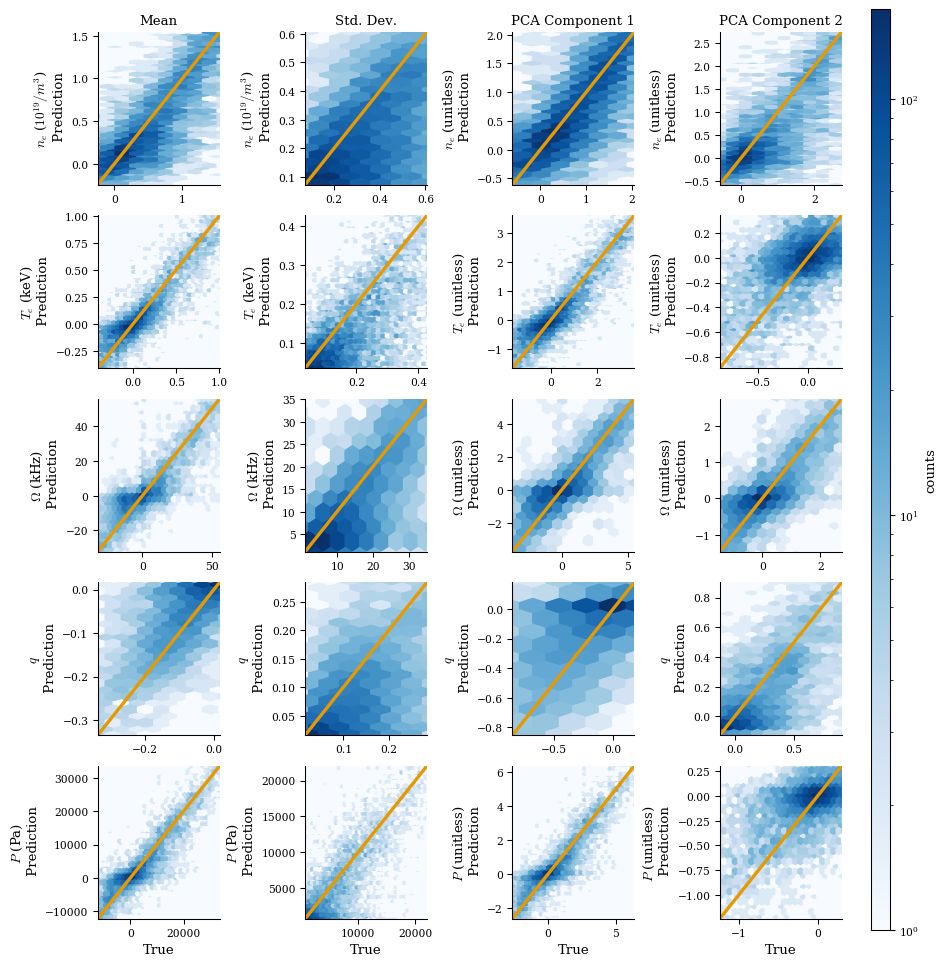

In [99]:
"""Scatter plot of deltas"""

ylabels = ['$n_e$','$T_e$','$\Omega$','$q$','$P$']
units = ['($10^{19}/m^3$)','(keV)','(kHz)','','(Pa)']
titles = ['Mean','Std. Dev.','PCA Component 1', 'PCA Component 2']
profiles = ['dens','temp','rotation','q_EFIT01','press_EFIT01']

fig, axes = plt.subplots(len(profiles),len(scalarize_function_names), figsize=(10,12))

for i,profile in enumerate(profiles):
    for j,name in enumerate(titles):

        pred=copy.deepcopy(predicted_delta[j][i])
        true=copy.deepcopy(true_delta[j][i])
      
        ax = axes[i,j]
        if name in ['Mean','Std. Dev.']:
            pred *= scenario['normalization_dict'][profile]['iqr']
            true *= scenario['normalization_dict'][profile]['iqr']
        bounds = find_bounds(true,pred)
        ax.set_xlim(bounds)
        ax.set_ylim(bounds)
        
        hb = ax.hexbin(true,pred,gridsize=100,bins='log',mincnt=0,cmap='Blues')
        # for raw
        x_45 = np.linspace(*ax.get_xlim())
        ax.plot(x_45, x_45,color=colorblind_colors[-1])
        if i==0:
            ax.set_title(name, size=labelsize)
        if i==len(profiles)-1:
            ax.set_xlabel('True',size=labelsize)
        if j in [0,1]:
            ax.set_ylabel(ylabels[i] + ' ' + units[i] + '\n Prediction', size=labelsize)
        if j in [2,3]:
            if ylabels[i] == '$q$':
                ax.set_ylabel(ylabels[i] + ' \n Prediction', size=labelsize)
            else:
                ax.set_ylabel(ylabels[i] + ' (unitless) \n Prediction', size=labelsize)
        ax.tick_params(axis='both', which='major', labelsize=ticksize)


plt.subplots_adjust(hspace=0.2,wspace=0.7,right=0.9)
cbar_ax = fig.add_axes([0.93, 0.1, 0.02, 0.8])
cb = fig.colorbar(hb, cax=cbar_ax)
cb.set_label('counts', size=labelsize)
cb.ax.tick_params(labelsize=ticksize)
# fig.savefig('pca_acc.png')

IndexError: index 3 is out of bounds for axis 1 with size 3

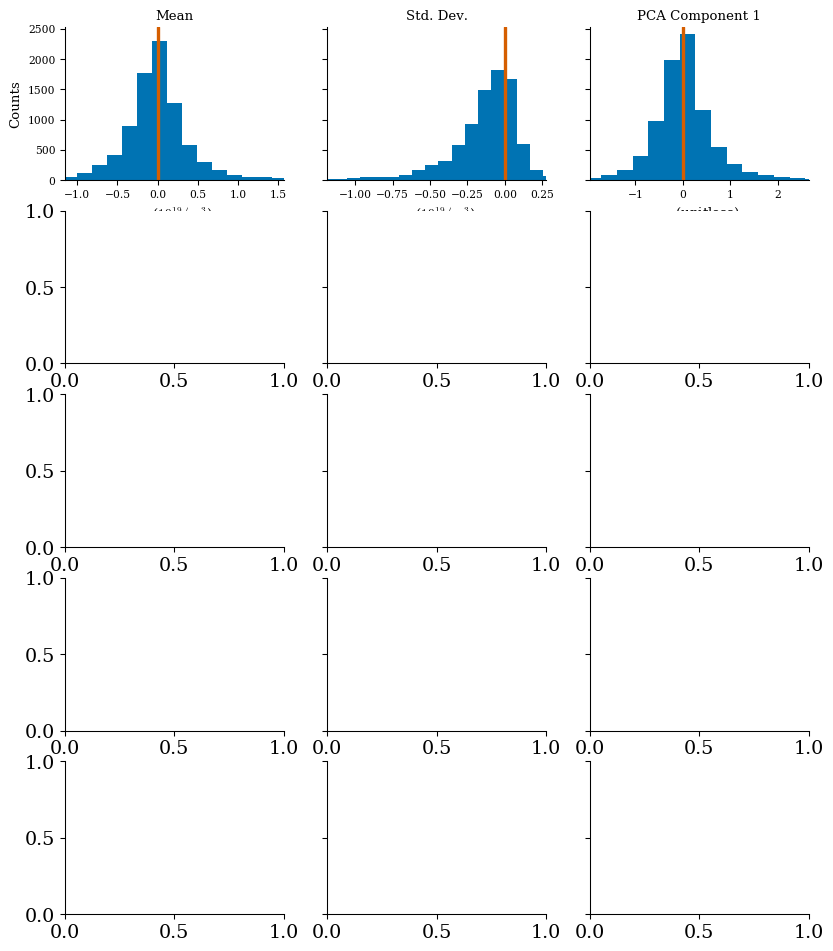

In [89]:
"""hist plot of deltas"""

ylabels = ['$n_e$','$T_e$','$\Omega$','$q$','$P$']
units = ['($10^{19}/m^3$)','(keV)','(kHz)','','(Pa)']
titles = ['Mean','Std. Dev.','PCA Component 1', 'PCA Component 2']
profiles = ['dens','temp','rotation','q_EFIT01','press_EFIT01']

fig, axes = plt.subplots(len(profiles),len(scalarize_function_names), sharey='row',figsize=(10,12))

for i,profile in enumerate(profiles):
    for j,name in enumerate(titles):

        pred=copy.deepcopy(predicted_delta[j][i])
        true=copy.deepcopy(true_delta[j][i])
      
        ax = axes[i,j]
        if name in ['Mean','Std. Dev.']:
            pred *= scenario['normalization_dict'][profile]['iqr']
            true *= scenario['normalization_dict'][profile]['iqr']
               

        arr = pred-true
        bounds=(np.percentile(arr, 1),np.percentile(arr, 99))
        ax.set_xlim(bounds)
        ax.hist(arr, bins=100, color=colorblind_colors[0])
  
        if i==0:
            ax.set_title(name, size=labelsize)
        if j==0:
            ax.set_ylabel('Counts', size=labelsize)
        if j in [0,1]:
            ax.set_xlabel(ylabels[i] + ' ' + units[i] + '\n [Prediction - True]', size=labelsize)
        if j in [2,3]:
            if ylabels[i] == '$q$':
                ax.set_xlabel(ylabels[i] + ' \n [Prediction - True]', size=labelsize)
            else:
                ax.set_xlabel(ylabels[i] + ' (unitless) \n [Prediction - True]', size=labelsize)
        ax.tick_params(axis='both', which='major', labelsize=ticksize)
        ax.axvline(0,color=colorblind_colors[1])


plt.subplots_adjust(hspace=.6,wspace=.2)

In [27]:
denormed_data = helpers.normalization.denormalize(traindata.copy(),scenario['normalization_dict'])
for sig in scenario['target_profile_names']:
    var = np.nanmean(np.nanstd(denormed_data[sig],axis=(-1,-2))/np.nanmean(denormed_data[sig],axis=(-1,-2)))
    print(sig, var)
    diffvar = np.mean(np.abs(np.diff(denormed_data[sig],axis=1))/np.mean(denormed_data[sig]))
    print(sig,diffvar)

Denormalizing: 100%|##########| 23/23 [00:00<00:00, 221.43it/s]


dens 0.25646165
dens 0.039824635
temp 0.5610617
temp 0.042584717
q_EFIT01 0.5578465
q_EFIT01 0.0196319


/home/wconlin/.conda/envs/tfgpu/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


rotation 0.5643371
rotation 0.060354747
press_EFIT01 0.6947234
press_EFIT01 0.0580707


In [28]:
denormed_data['dens'].shape

(26096, 5, 65)

# Plot average error vs baseline

In [14]:
train_generator_batch = DataGenerator(traindata,
                                128, #scenario['batch_size'],
                                scenario['input_profile_names'],
                                scenario['actuator_names'],
                                scenario['target_profile_names'],
                                scenario['scalar_input_names'],
                                scenario['lookbacks'],
                                scenario['lookahead'],
                                scenario['predict_deltas'],
                                scenario['profile_downsample'],
                                False,
                                sample_weights = None) #scenario['shuffle_generators'])

predictions_arr = model.predict_generator(train_generator_batch)

In [15]:
   
def scalarize_mean(arr, **kwargs):
    return np.mean(arr)

def scalarize_std(arr, **kwargs):
    return np.std(arr)

def scalarize_pca_1(arr, **kwargs):
    fitter = kwargs.get('fitter')
    ret = fitter.transform(arr).squeeze()[0]
    return ret

def scalarize_pca_2(arr, **kwargs):
    fitter = kwargs.get('fitter')
    ret = fitter.transform(arr).squeeze()[1]
    return ret

def scalarize_pca_3(arr, **kwargs):
    fitter = kwargs.get('fitter')
    ret = fitter.transform(arr).squeeze()[2]
    return ret

def scalarize_pca_4(arr, **kwargs):
    fitter = kwargs.get('fitter')
    ret = fitter.transform(arr).squeeze()[3]
    return ret

def scalarize_pca_5(arr, **kwargs):
    fitter = kwargs.get('fitter')
    ret = fitter.transform(arr).squeeze()[4]
    return ret

def scalarize_pca_6(arr, **kwargs):
    fitter = kwargs.get('fitter')
    ret = fitter.transform(arr).squeeze()[5]
    return ret

In [16]:
baseline = {sig:[] for sig in scenario['target_profile_names']}
for i in range(len(train_generator_batch)):
    print(i,end=',')
    sample = train_generator_batch[i]
    for sig in scenario['target_profile_names']:
        baseline[sig].append(sample[1]['target_'+sig])
baseline = {sig:np.concatenate(baseline[sig],axis=0) for sig in scenario['target_profile_names']}

0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,

In [17]:
predictions = {sig: arr for sig, arr in zip(scenario['target_profile_names'],predictions_arr)}

In [18]:
model_err = {sig: np.abs(predictions[sig] - baseline[sig]) for sig in scenario['target_profile_names']}
baseline_err = {sig: np.abs(baseline[sig]) for sig in scenario['target_profile_names']}


In [19]:
hi_per = 75
low_per = 25

med_model_err = {sig:np.median(model_err[sig]*scenario['normalization_dict'][sig]['iqr'],axis=0) for sig in scenario['target_profile_names']}
med_baseline_err = {sig:np.median(baseline_err[sig]*scenario['normalization_dict'][sig]['iqr'],axis=0) for sig in scenario['target_profile_names']}

med_model_hiper = {sig:np.percentile(model_err[sig]*scenario['normalization_dict'][sig]['iqr'],hi_per,axis=0) for sig in scenario['target_profile_names']}
med_baseline_hiper = {sig:np.percentile(baseline_err[sig]*scenario['normalization_dict'][sig]['iqr'],hi_per,axis=0) for sig in scenario['target_profile_names']}

med_model_lowper = {sig:np.percentile(model_err[sig]*scenario['normalization_dict'][sig]['iqr'],low_per,axis=0) for sig in scenario['target_profile_names']}
med_baseline_lowper = {sig:np.percentile(baseline_err[sig]*scenario['normalization_dict'][sig]['iqr'],low_per,axis=0) for sig in scenario['target_profile_names']}

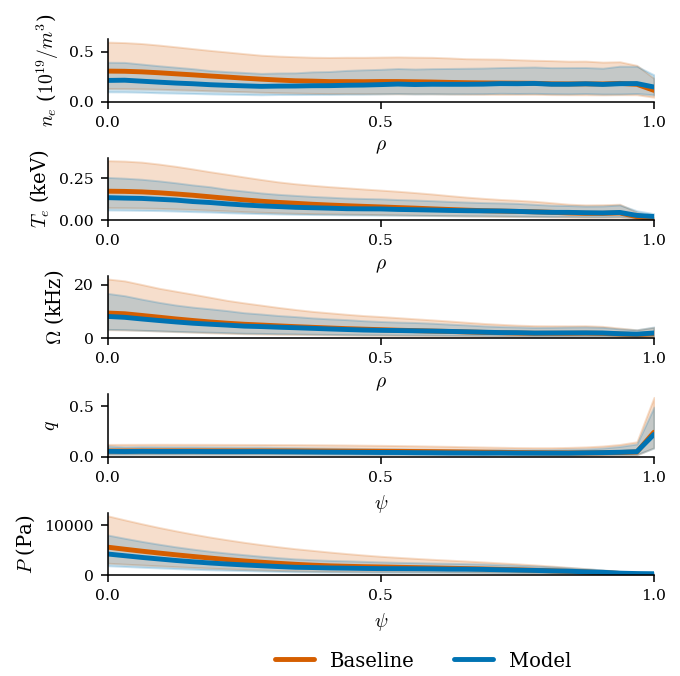

In [20]:
labels = ['$n_e$ ($10^{19}/m^3$)','$T_e$ (keV)','$\Omega$ (kHz)','$q$','$P$ (Pa)']
profiles = ['dens','temp','rotation','q_EFIT01','press_EFIT01']
# profiles = ['dens','temp','rotation','q','itemp']
# labels = ['$n_e$ ($10^{19}/m^3$)','$T_e$ (keV)','$\Omega$ (kHz)','$q$','$T_i$ (keV)']


fig, ax = plt.subplots(len(profiles),1,figsize=(5,5))
for i, sig in enumerate(profiles):
    
    ax[i].plot(psi,med_baseline_err[sig],c=colorblind_colors[1],label='Baseline')
    ax[i].fill_between(psi,med_baseline_lowper[sig],med_baseline_hiper[sig],color=colorblind_colors[1],alpha=0.2)   
    ax[i].plot(psi,med_model_err[sig],c=colorblind_colors[0],label='Model')
    ax[i].fill_between(psi,med_model_lowper[sig],med_model_hiper[sig],color=colorblind_colors[0],alpha=0.2)    

    ax[i].set_ylim(0,None)
    ax[i].set_ylabel(labels[i],size=labelsize)
    ax[i].tick_params(axis='both', which='major', labelsize=ticksize)
#     if i==2:
#         ax[i].legend(fontsize=labelsize)
    ax[i].set_xticks([0,.5,1])
    ax[i].set_xlim(0,1)
    if i in [0,1,2]:
        ax[i].set_xlabel('$\\rho$',size=labelsize)
    if i in [3,4]:
        ax[i].set_xlabel('$\psi$',size=labelsize)

# ax[4].set_yticks([0,10000])
# ax[4].set_yticklabels(['0',r'$10^4$'])
plt.subplots_adjust(hspace=0.9, bottom=0.12)
fig.legend(handles=ax[0].lines,     
           labels=[line._label for line in ax[0].lines],  
           loc="upper center",
           bbox_to_anchor=(0.6, 0.06),
           frameon=False,
           mode=None,
           ncol=2,
          fontsize=labelsize)
# fig.savefig('average_error.pdf',bbox_inches='tight',pad_inches=0.1)
# fig.savefig('average_error.png',bbox_inches='tight',pad_inches=0.1)

In [23]:
scalarize_functions=[scalarize_mean, scalarize_pca_1,scalarize_pca_2]
scalarize_function_names=['mean','pca 1','pca 2']
profiles = ['dens','temp','rotation','q_EFIT01','press_EFIT01']
# profiles = ['dens','temp','rotation','q','itemp']

num_samples = len(traindata['time'])
all_true_delta=np.zeros((len(scalarize_functions),len(profiles),num_samples))
all_predicted_delta=np.zeros((len(scalarize_functions),len(profiles),num_samples))

for j,profile in enumerate(profiles):
    for k in range(num_samples):
        target = baseline[profile][k][np.newaxis,:]
        pred = predictions[profile][k][np.newaxis,:]
        for i,scalarize in enumerate(scalarize_functions):
            all_true_delta[i][j][k]=scalarize(target, fitter=full_pca_fitter[profile])
            all_predicted_delta[i][j][k]=scalarize(pred, fitter=full_pca_fitter[profile])   


In [24]:
def find_bounds(true,pred,percentile=90):
    arr = np.concatenate([true,pred]).flatten()
  
    true_bounds=(np.percentile(true, 50-percentile/2),np.percentile(true, 50+percentile/2))
    pred_bounds=(np.percentile(pred, 50-percentile/2),np.percentile(pred, 50+percentile/2))
#     bounds=(mean-3*std,mean+3*std)
    return (np.maximum(true_bounds[0],pred_bounds[0]),np.minimum(true_bounds[1],pred_bounds[1]))

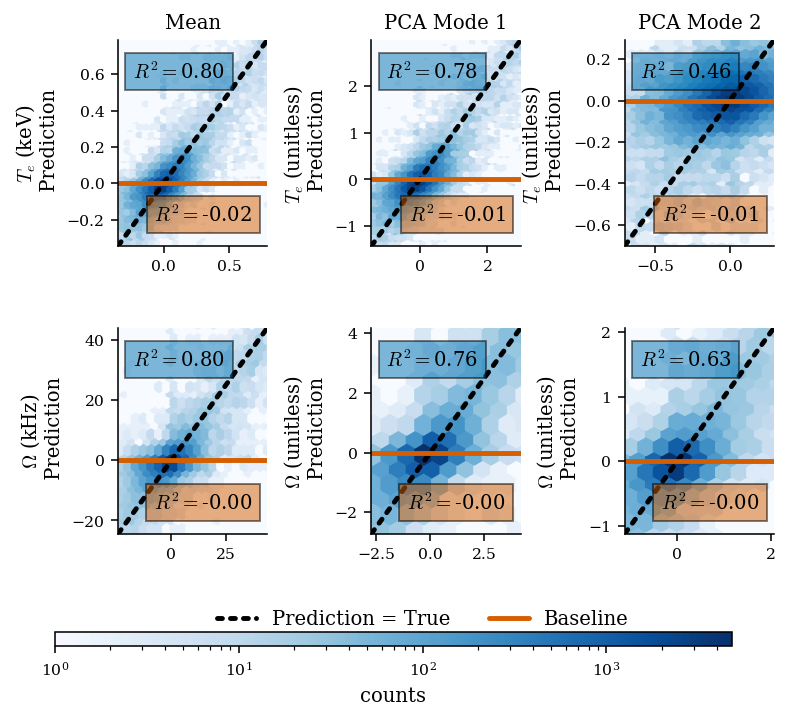

In [40]:
"""Scatter plot of deltas"""

labels = ['$n_e$','$T_e$','$\Omega$','$q$','$P$']
units = ['($10^{19}/m^3$)','(keV)','(kHz)','','(Pa)']
titles = ['Mean','PCA Mode 1', 'PCA Mode 2']
profiles = ['dens','temp','rotation','q_EFIT01','press_EFIT01']

# profiles = ['dens','temp','rotation','q','itemp']
# labels = ['$n_e$ ($10^{19}/m^3$)','$T_e$ (keV)','$\Omega$ (kHz)','$q$','$T_i$ (keV)']

# fig, axes = plt.subplots(len(profiles),len(scalarize_function_names), figsize=(5,6))
fig, axes = plt.subplots(2,len(scalarize_function_names), figsize=(6,5))

for i,profile in enumerate(profiles):
    if profile in ['temp','rotation']:
        for j,name in enumerate(titles):

            pred=copy.deepcopy(all_predicted_delta[j][i])
            true=copy.deepcopy(all_true_delta[j][i])

            ax = axes[i-1,j]
            if name in ['Mean','Std. Dev.']:
                pred *= scenario['normalization_dict'][profile]['iqr']
                true *= scenario['normalization_dict'][profile]['iqr']
            bounds = find_bounds(true,pred,95)
            ax.set_xlim(bounds)
            ax.set_ylim(bounds)

            r2_model = r2_score(true,pred)
            r2_baseline = r2_score(true, np.zeros(true.shape))

            hb = ax.hexbin(true,pred,gridsize=100,bins='log',mincnt=0,cmap='Blues')
            ax.text(0.1, 0.9, '$R^2=${:.2f}'.format(r2_model), fontsize=labelsize, horizontalalignment='left',verticalalignment='top', 
                    transform=ax.transAxes,bbox=dict(facecolor=colorblind_colors[0], alpha=0.5))
            ax.text(0.9, 0.1, '$R^2=${:.2f}'.format(r2_baseline), fontsize=labelsize, horizontalalignment='right',verticalalignment='bottom', 
                    transform=ax.transAxes,bbox=dict(facecolor=colorblind_colors[1], alpha=0.5)) 

            x_45 = np.linspace(*ax.get_xlim())
            ax.plot(x_45, x_45,color='k', linestyle=':',label='Prediction = True')
            ax.axhline(0,color=colorblind_colors[1],label='Baseline')
            if i==1:
                ax.set_title(name, size=labelsize)
            if i==len(profiles)-1:
                ax.set_xlabel('True',size=labelsize)
            if j in [0]:
                ax.set_ylabel(labels[i] + ' ' + units[i] + '\n Prediction', size=labelsize)
            if j in [1,2,3]:
                if ylabels[i] == '$q$':
                    ax.set_ylabel(labels[i] + ' \n Prediction', size=labelsize)
                else:
                    ax.set_ylabel(labels[i] + ' (unitless) \n Prediction', size=labelsize)
            ax.tick_params(axis='both', which='major', labelsize=ticksize)

# axes[4,0].set_yticks([0,20000])
# axes[4,0].set_yticklabels(['0',r'2$\times 10^4$'])
# axes[4,0].set_xticks([0,20000])
# axes[4,0].set_xticklabels(['0',r'2$\times 10^4$'])
plt.subplots_adjust(hspace=0.4,wspace=.7,bottom=0.18)
cbar_ax = fig.add_axes([0.05, 0.02, 0.8, 0.02])
cb = fig.colorbar(hb, cax=cbar_ax, orientation='horizontal')
cb.set_label('counts', size=labelsize)
cb.ax.tick_params(labelsize=ticksize)
fig.legend(handles=axes[0,0].lines,     
           labels=[line._label for line in axes[0,0].lines],  
           loc="upper center",
           bbox_to_anchor=(0.5, 0.18),
           frameon=False,
           mode=None,
           ncol=2,
           fontsize=labelsize)
# fig.savefig('all_pca_acc.pdf',bbox_inches='tight',pad_inches=0.1)
# fig.savefig('all_pca_acc.png',bbox_inches='tight',pad_inches=0.1)

In [ ]:
"""hist plot of deltas"""

ylabels = ['$n_e$','$T_e$','$\Omega$','$q$','$P$']
units = ['($10^{19}/m^3$)','(keV)','(kHz)','','(Pa)']
titles = ['Mean\nError','PCA Mode 1\nError', 'PCA Mode 2\nError']
profiles = ['dens','temp','rotation','q_EFIT01','press_EFIT01']

fig, axes = plt.subplots(len(profiles),len(scalarize_function_names), sharey='row',figsize=(4,8))

for i,profile in enumerate(profiles):
    for j,name in enumerate(titles):

        pred=copy.deepcopy(all_predicted_delta[j][i])
        true=copy.deepcopy(all_true_delta[j][i])
      
        ax = axes[i,j]
        if name in ['Mean','Std. Dev.']:
            pred *= scenario['normalization_dict'][profile]['iqr']
            true *= scenario['normalization_dict'][profile]['iqr']
               

        arr = pred-true
        bounds = find_bounds(-true,arr,99.9)
        ax.set_xlim(bounds)
        bins=100
        h0 = ax.hist(-true, bins=bins, range=bounds, histtype='stepfilled',log=True,color=colorblind_colors[1], alpha=0.2)
        h1 = ax.hist(-true, bins=bins, range=bounds, histtype='step',color=colorblind_colors[1], lw=2, label='Baseline')
        h2 = ax.hist(arr, bins=bins, range=bounds, histtype='stepfilled', color=colorblind_colors[0], alpha=0.2)
        h2 = ax.hist(arr, bins=bins, range=bounds, histtype='step', color=colorblind_colors[0], lw=2, label='Model')
        if i==0:
            ax.set_title(name, size=labelsize)
        if j==0:
            ax.set_ylabel('Counts', size=labelsize)
        if name in ['Mean\nError','Std. Dev.\nError']:
            ax.set_xlabel(ylabels[i] + ' ' + units[i], size=labelsize)
        else:
            if ylabels[i] == '$q$':
                ax.set_xlabel(ylabels[i], size=labelsize)
            else:
                ax.set_xlabel(ylabels[i] + ' (unitless)', size=labelsize)
        ax.tick_params(axis='both', which='major', labelsize=ticksize)
        ax.axvline(0,color='k', linestyle=':')

# cbar_ax = fig.add_axes([0.0, 0.1, 0.8, 0.05])
fig.legend(handles=[h1[2][0],h2[2][0]],     
           labels=[line._label for line in [h1[2][0],h2[2][0]]],  
           loc='upper center',
           bbox_to_anchor=(0.5, 0.06),
           frameon=False,
           mode=None,
           ncol=2,
           fontsize=labelsize)
plt.subplots_adjust(hspace=.6,wspace=.2, bottom=0.12)
# fig.savefig('all_hist_acc.pdf',bbox_inches='tight',pad_inches=0.1)
# fig.savefig('all_hist_acc.png',bbox_inches='tight',pad_inches=0.1)

In [68]:
model.get_layer('target_q').input.name

'conv2d_24_1/BiasAdd:0'

In [66]:
model.get_layer('conv2d_24').get_weights()

[array([[[[-0.30306318],
          [-0.1707437 ],
          [-0.33381936],
          [-0.0385584 ]],
 
         [[-0.0540573 ],
          [-0.24847983],
          [ 0.24522   ],
          [ 0.31177956]],
 
         [[-0.0262728 ],
          [ 0.31098342],
          [ 0.14075193],
          [-0.28889716]],
 
         [[ 0.10010893],
          [-0.16277094],
          [ 0.09445713],
          [-0.19416237]],
 
         [[-0.03605627],
          [-0.09471779],
          [ 0.38246328],
          [-0.32473135]],
 
         [[-0.21931279],
          [ 0.31287503],
          [-0.1657753 ],
          [-0.33504578]],
 
         [[ 0.29783463],
          [-0.00551656],
          [-0.1619631 ],
          [-0.04987375]],
 
         [[-0.26798236],
          [ 0.32200062],
          [ 0.29185814],
          [ 0.11493427]]]], dtype=float32),
 array([-0.01005634], dtype=float32)]

In [67]:
model.get_layer('conv2d_24').get_config()

{'name': 'conv2d_24',
 'trainable': True,
 'filters': 1,
 'kernel_size': (1, 8),
 'strides': (1, 1),
 'padding': 'same',
 'data_format': 'channels_last',
 'dilation_rate': (1, 1),
 'activation': 'linear',
 'use_bias': True,
 'kernel_initializer': {'class_name': 'VarianceScaling',
  'config': {'scale': 1.0,
   'mode': 'fan_avg',
   'distribution': 'uniform',
   'seed': None}},
 'bias_initializer': {'class_name': 'Zeros', 'config': {}},
 'kernel_regularizer': None,
 'bias_regularizer': None,
 'activity_regularizer': None,
 'kernel_constraint': None,
 'bias_constraint': None}

In [88]:
train_generator = DataGenerator(traindata,
                                1, #scenario['batch_size'],
                                scenario['input_profile_names'],
                                scenario['actuator_names'],
                                scenario['target_profile_names'],
                                scenario['scalar_input_names'],
                                scenario['lookbacks'],
                                scenario['lookahead'],
                                scenario['predict_deltas'],
                                scenario['profile_downsample'],
                                False,
                                sample_weights = 'std') #scenario['shuffle_generators'])

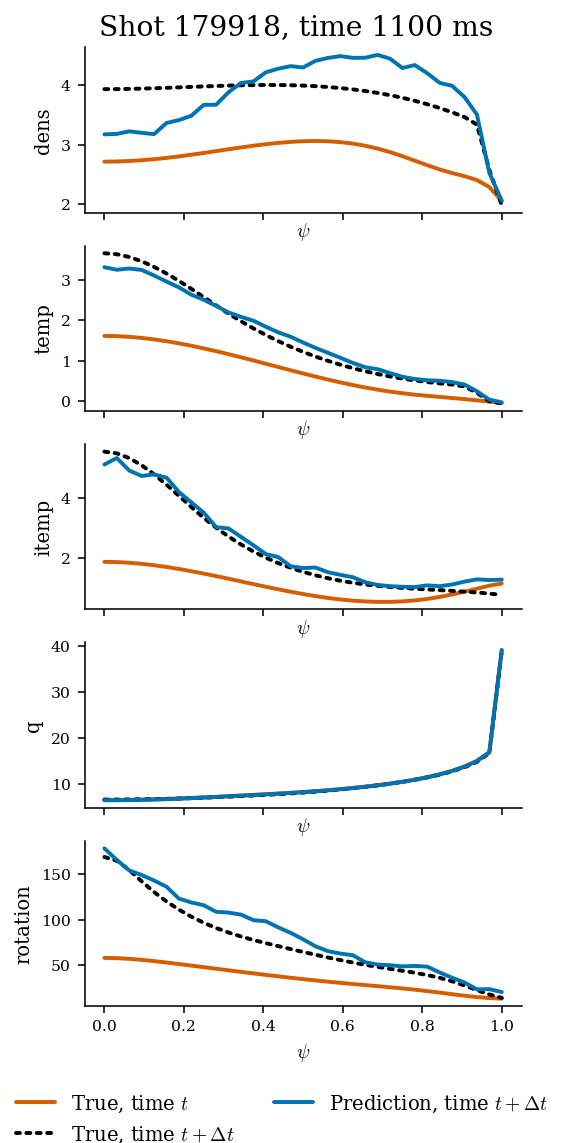

In [120]:


index = 94117
index = 1
index = np.random.randint(len(train_generator))
inputs, targets,_ = train_generator[index]
profiles = scenario['input_profile_names']
# inputs,targets,_ = train_generator.get_data_by_shot_time([163303],[12])
# inputs = inputs[index]
# targets = targets[index]

shotnum = train_generator.cur_shotnum[0,0]
shottime = train_generator.cur_times[0,-scenario['lookahead']-1]

predictions=model.predict_on_batch(inputs)
ylabels = profiles #['$n_e$','$T_e$ (keV)','$q$','$\Omega$','$P$ (kPa)']

fig, axes = plt.subplots(len(profiles),1,sharex=True, figsize=(4,8))
for j, profile in enumerate(profiles):
    ax = axes[j]
    inp = inputs['input_{}'.format(profile)].squeeze()
    true = inputs['input_{}'.format(profile)].squeeze() + targets['target_{}'.format(profile)].squeeze()
    pred = inputs['input_{}'.format(profile)].squeeze() + predictions[j].squeeze()

    inp = helpers.normalization.denormalize_arr(inp,normalization_dict[profile])
    true = helpers.normalization.denormalize_arr(true,normalization_dict[profile])
    pred = helpers.normalization.denormalize_arr(pred,normalization_dict[profile])

    ax.plot(psi,inp,lw=2,label='True, time $t$',c=colorblind_colors[1])
    ax.plot(psi,true,lw=2,label='True, time $t+\Delta t$',c='k',ls=':')
    ax.plot(psi,pred,lw=2,label='Prediction, time $t+\Delta t$',c=colorblind_colors[0])
    ax.set_ylabel(ylabels[j],size=10)
#     title = ''
#     title += 'mse: {:.2e}'.format(mse(true,pred))
#     title += '\n mae: {:.2e}'.format(mae(true,pred))
#     title += '\n normmse: {:.2e}'.format(normed_mse(true,pred))
#     ax.set_title(title)
    ax.set_xlabel('$\psi$',size=10)
    ax.tick_params(axis='both', which='major', labelsize=8)

plt.subplots_adjust(top=.95,bottom=.1)
fig.suptitle("Shot {}, time {} ms".format(int(shotnum), int(shottime)))
fig.legend(handles=axes[0].lines,     
           labels=[line._label for line in axes[0].lines],  
           loc="upper center",
           bbox_to_anchor=(0.5, 0.06),
           frameon=False,
           mode=None,
           ncol=2,
          fontsize=labelsize)
# fig.savefig('prof_pred_ex.png')

In [39]:
def mse(true,pred):
    return np.mean((pred-true)**2)

def mae(true,pred):
    return np.mean(np.abs(true-pred))

def normed_mse(true,pred):
    num = np.mean((pred-true)**2)
    den = (np.mean((true)**2))
    return np.sqrt(num/den)

In [24]:
orig_data_path = '/scratch/gpfs/jabbate/full_data/train_data_full.pkl'
test_data_path = '/scratch/gpfs/jabbate/full_data_with_error/test_data.pkl' 
traindata, valdata, normalization_dict = helpers.data_generator.process_data(orig_data_path,
                                                      scenario['sig_names'],
                                                      scenario['normalization_method'],
                                                      scenario['window_length'],
                                                      scenario['window_overlap'],
                                                      {sig:6 for sig in scenario['sig_names']},
                                                      scenario['lookahead'],
                                                      scenario['sample_step'],
                                                      scenario['uniform_normalization'],
                                                      1, #scenario['train_frac'],
                                                      0, #scenario['val_frac'],
                                                      scenario['nshots'],
                                                      2, #scenario['verbose']
                                                      scenario['flattop_only'],
                                                      randomize=False,
                                                      pruning_functions=scenario['pruning_functions'],
                                                      excluded_shots = scenario['excluded_shots'],
                                                      delta_sigs = [])
traindata = helpers.normalization.renormalize(helpers.normalization.denormalize(traindata.copy(),normalization_dict),scenario['normalization_dict'])


Loading
Signals: bt, curr_target, dens, density_estimate, li_EFIT01, pinj, press_EFIT01, q_EFIT01, rotation, target_density, temp, tinj, triangularity_bot_EFIT01, triangularity_top_EFIT01, volume_EFIT01
Number of useable shots:  6894
Number of shots used:  6894
Total number of timesteps:  723571
Shots with Complete NaN: 
489731 samples total
Removing ECH
Removed 207165 samples
282566 samples remaining
Removing timesteps WITHOUT gas feedback
Removed 53966 samples
228600 samples remaining
Removing weird I-coils
Removed 50255 samples
178345 samples remaining
Removing NaN
Removed 0 samples
178345 samples remaining
Removing dudtrip
Removed 9969 samples
168376 samples remaining
168376 samples remaining after pruning


Denormalizing:   0%|          | 0/23 [00:00<?, ?it/s]

Total number of samples:  168376
Number of training samples:  168376
Number of validation samples:  0


Normalizing: 100%|##########| 23/23 [00:09<00:00,  2.49it/s]


In [42]:
traindata = helpers.normalization.denormalize(traindata.copy(), scenario['normalization_dict'])


Denormalizing: 100%|##########| 23/23 [00:01<00:00, 16.21it/s]


In [69]:
def iqr(x,axis):
    return np.subtract(*np.percentile(x, [75, 25], axis=axis))

def total_variation(x,axis):
    if x.ndim==2:
        return np.mean(np.abs(x-x.mean(axis=1)[:,np.newaxis]),axis=1)
    if x.ndim==3:
        return np.mean(np.abs(x-x.mean(axis=1)[:,np.newaxis,:]),axis=(1,2))
    
def abs_diff(x,axis):
    if x.ndim==2:
        return np.mean(np.abs(np.diff(x,axis=1)/0.5),axis=1)
    if x.ndim==3:
        return np.mean(np.abs(np.diff(x,axis=1)/0.5),axis=(1,2))

In [91]:
traindata['q0'] = traindata['q_EFIT01'][:,:,0]
traindata['q95'] = traindata['q_EFIT01'][:,:,62]

In [92]:
.95*65

61.75

In [95]:
metric_functions = {'mean': np.mean,
                    'median': np.median,
                    'std': np.std,
                    'variance': np.var,
                    'iqr': iqr,
                    'total_variation': total_variation,
                    'abs_diff': abs_diff,
                    'skewness': scipy.stats.skew,
                    'kurtosis': scipy.stats.kurtosis}
actuators = ['pinj','curr_target','tinj','target_density']
profiles = ['dens','temp','q_EFIT01','rotation','press_EFIT01','q0','q95']

In [96]:
params = {}
for key, value in traindata.items():
    if key in actuators or key in profiles:
        for metric, fn in metric_functions.items():
            if value.ndim>2:
                params[key + '-' + metric] = fn(value[:,6,:], axis=-1).flatten()
            else:
                params[key + '-' + metric] = fn(value, axis=-1).flatten()
            print(key,metric)

curr_target mean
curr_target median
curr_target std
curr_target variance
curr_target iqr
curr_target total_variation
curr_target abs_diff
curr_target skewness
curr_target kurtosis
dens mean
dens median
dens std
dens variance
dens iqr
dens total_variation
dens abs_diff
dens skewness
dens kurtosis
pinj mean
pinj median
pinj std
pinj variance
pinj iqr
pinj total_variation
pinj abs_diff
pinj skewness
pinj kurtosis
press_EFIT01 mean
press_EFIT01 median
press_EFIT01 std
press_EFIT01 variance
press_EFIT01 iqr
press_EFIT01 total_variation
press_EFIT01 abs_diff
press_EFIT01 skewness
press_EFIT01 kurtosis
q_EFIT01 mean
q_EFIT01 median
q_EFIT01 std
q_EFIT01 variance
q_EFIT01 iqr
q_EFIT01 total_variation
q_EFIT01 abs_diff
q_EFIT01 skewness
q_EFIT01 kurtosis
rotation mean
rotation median
rotation std
rotation variance
rotation iqr
rotation total_variation
rotation abs_diff
rotation skewness
rotation kurtosis
target_density mean
target_density median
target_density std
target_density variance
target

In [97]:
params['temp-abs_diff'].shape

(168376,)

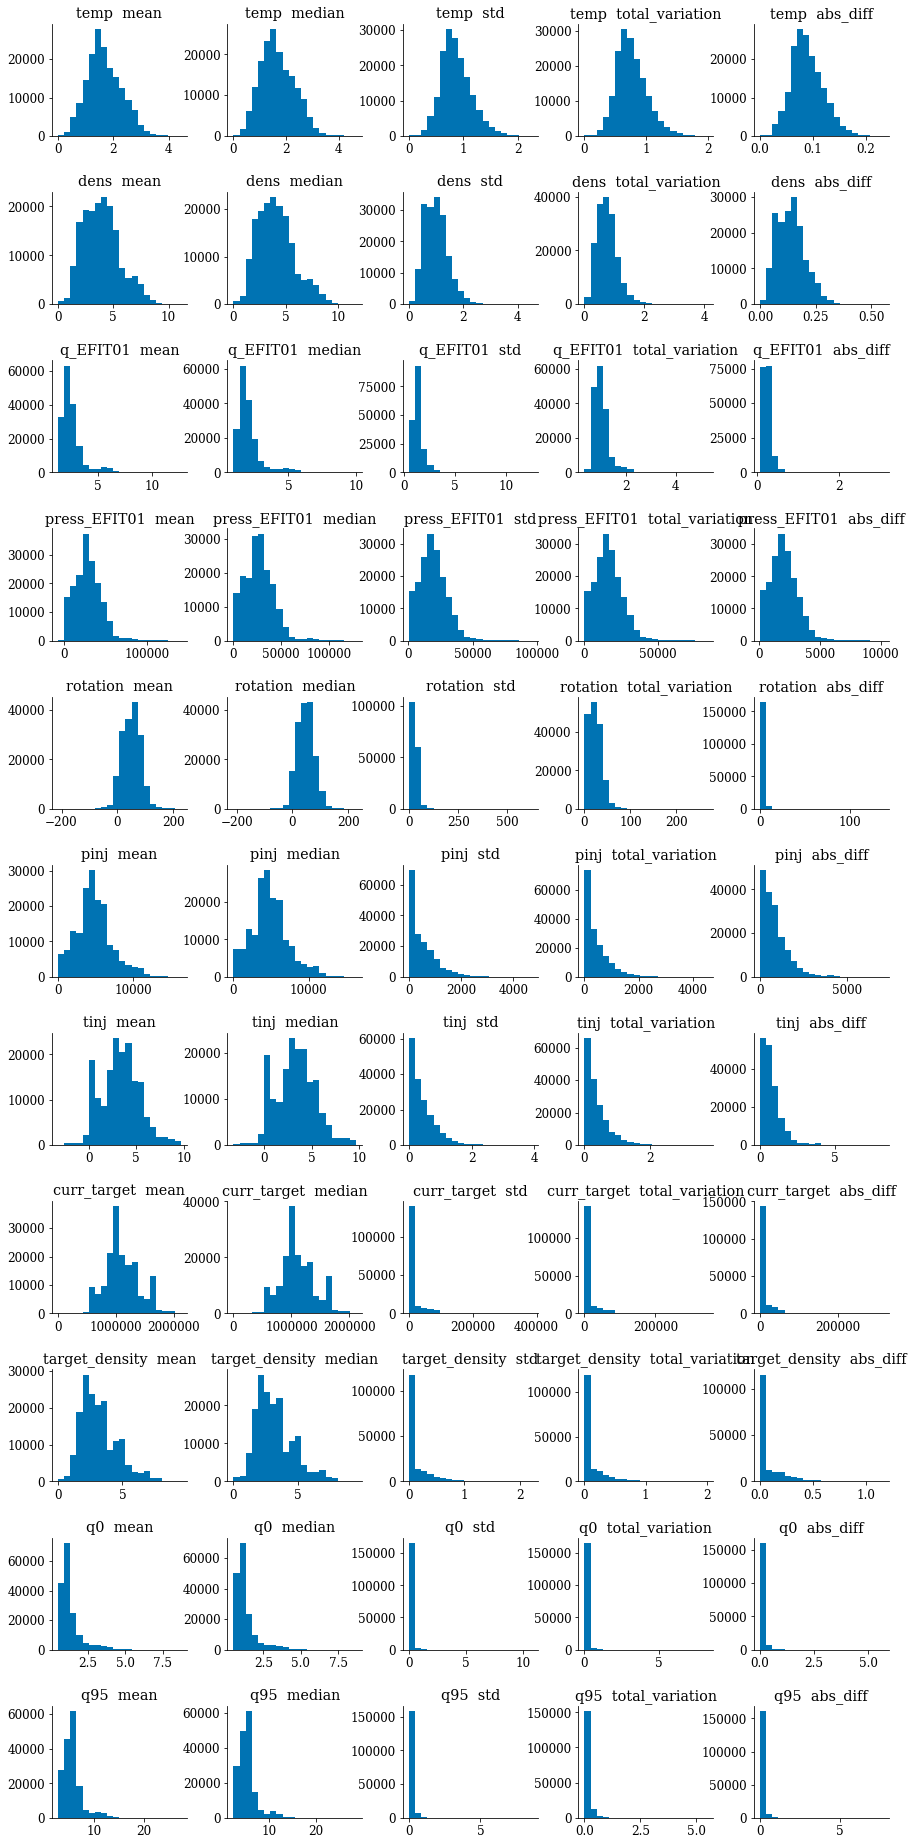

In [98]:
metrics = ['mean','median','std','total_variation','abs_diff']
sigs = ['temp','dens','q_EFIT01','press_EFIT01','rotation','pinj','tinj','curr_target','target_density','q0','q95']

nrows = len(sigs)
ncols = len(metrics)
figsize = (ncols*3,nrows*3)
bins=20
fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize)
for i, sig in enumerate(sigs):
    for j, metric in enumerate(metrics):
        ax[i,j].hist(params[sig + '-' + metric], bins=bins, log=False)
        ax[i,j].title.set_text(sig + '  ' + metric)

plt.subplots_adjust(hspace=0.5, wspace=0.3)

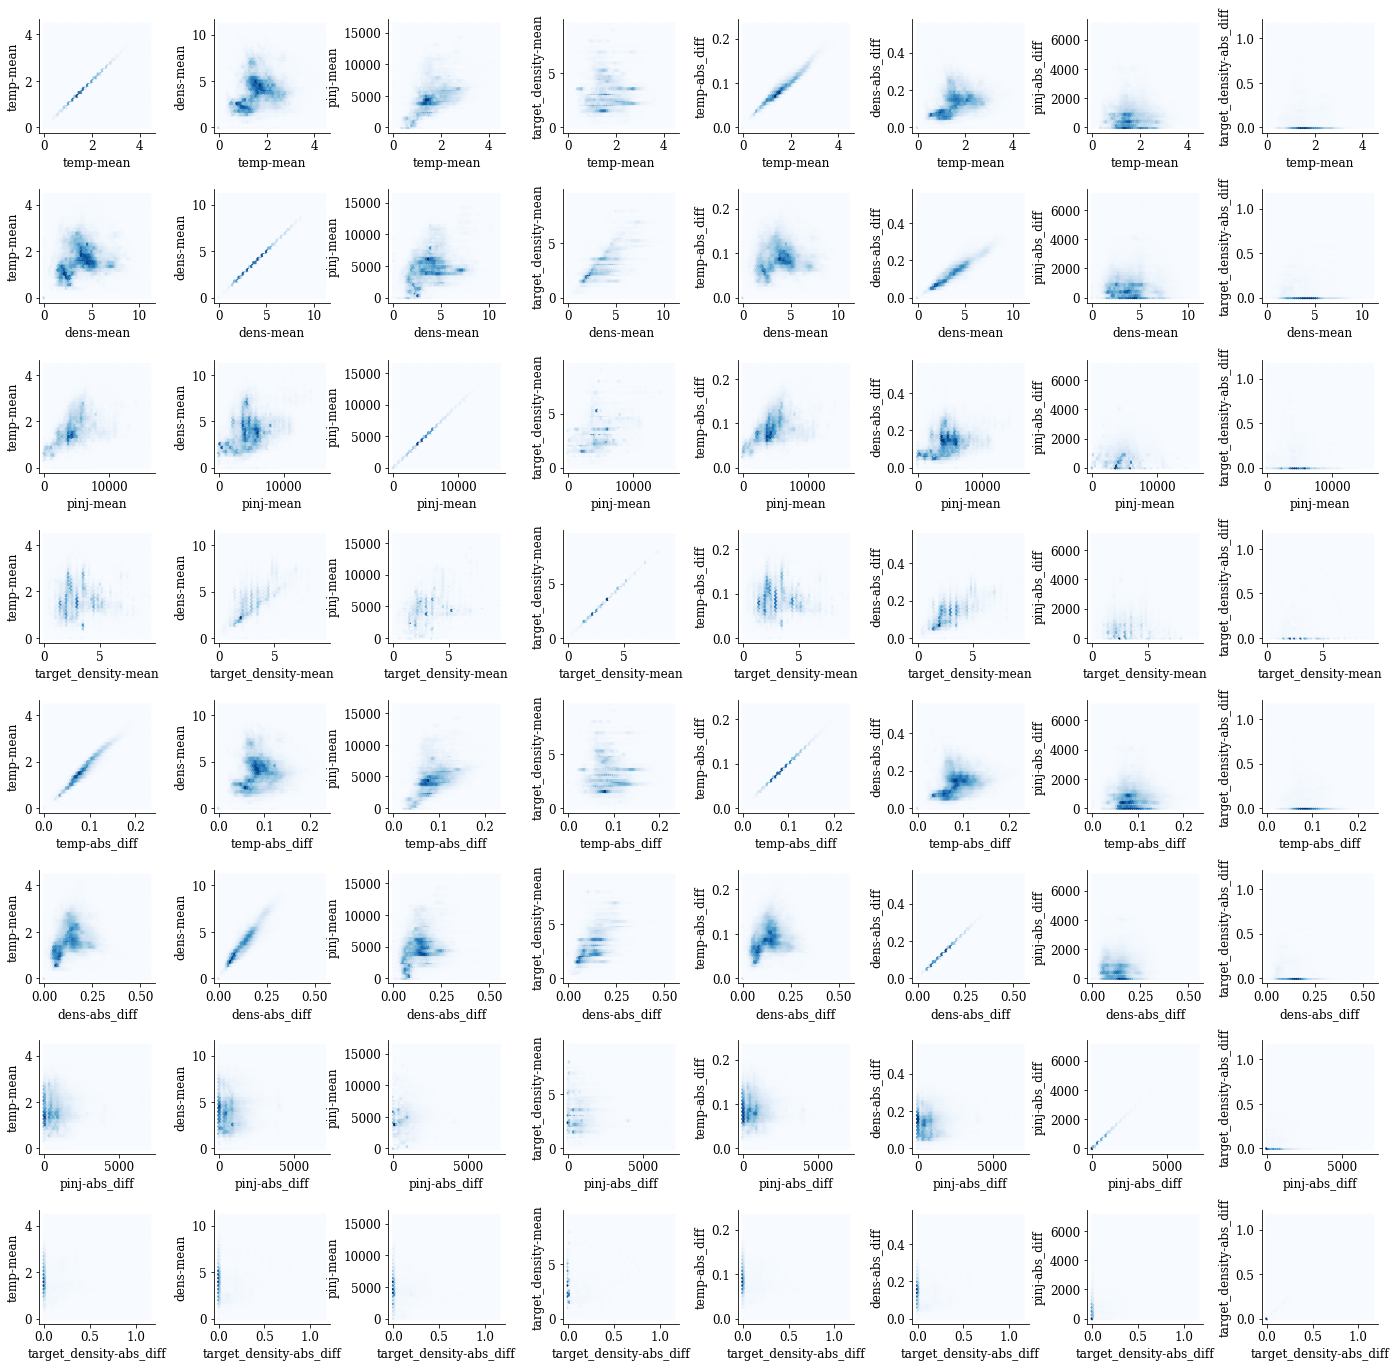

In [81]:
metrics = ['mean','abs_diff']
profiles = ['temp','dens','pinj','target_density']
labels = [profile + '-' +  metric for metric in metrics for profile in profiles]

nsamples = params['temp-mean'].size
nrows = len(labels)
ncols = len(labels)
figsize = (ncols*3,nrows*3)
bins = None #np.linspace(0,nsamples,20)
alpha = 1
xrange = [-3,3]
yrange = [-3,3]
cmap = 'Blues'
fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize)
for i, label1 in enumerate(labels):
    for j, label2 in enumerate(labels): 
            ax[i,j].hexbin(params[label1], params[label2], gridsize=50, bins=bins, cmap=cmap, alpha=alpha)
            ax[i,j].set_xlabel(label1)
            ax[i,j].set_ylabel(label2)
plt.subplots_adjust(hspace=0.5,wspace=0.5)


In [85]:
metrics = ['mean','abs_diff']
profiles = ['temp','dens','pinj','target_density']
labels = [['temp-mean','pinj-abs_diff'],['dens-mean','target_density-abs_diff']]

nsamples = params['temp-mean'].size
nrows = len(labels)
ncols = 1
figsize = (5,nrows*3)
bins = None #np.linspace(0,nsamples,20)
alpha = 1
cmap = 'Blues'
fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize)
for i, label in enumerate(labels):
        ax[i].hexbin(params[label[0]], params[label[1]], gridsize=50, bins=bins, cmap=cmap, alpha=alpha)
        ax[i].set_xlabel(label[0])
        ax[i].set_ylabel(label[1])
plt.subplots_adjust(hspace=0.5,wspace=0.5)

NameError: name 'params' is not defined

In [73]:
a = model.get_weights()

In [74]:
len(a)

88

In [76]:
s=0
s2=0
c=0
for foo in a:
    s += np.sum(np.abs(foo))
    s2 += np.sum(foo**2)
    c += foo.size

In [77]:
s

37155.861784268694

In [78]:
s2

4217.80743501655

In [79]:
c

660467

In [83]:
s/c

0.05625695422219232

In [84]:
s2/c

0.006386098677173197